In [2]:
import sys
import taffmat

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Importing Data

## Define Data Folders

In [55]:
parent_data_folder = "F:/Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data"
TEAC_raw_data_folder = parent_data_folder + "/TEAC/Raw Data/"
TEAC_test_name = "LX20_001"

TEAC_raw_url = TEAC_raw_data_folder + TEAC_test_name

TEAC_raw_url = "F:/Dropbox/Projects/011 - UofC Leak/Test/June 5/Station 2 - Energy Center/TEAC/LX120DIR/LX20_001"
#TEAC_raw_url = "F:/Dropbox/Projects/011 - UofC Leak/Test/June 5/Station 3 - Manhole/TEAC/LX110DIR/LX10_002"

## Read and Import Data

In [56]:
# read_taffmat returns tuple containing three elements: a 2D NumPy array, a 1D NumPy array, and an OrderedDict with metadata
test_raw_data = taffmat.read_taffmat(TEAC_raw_url)

In [57]:
#data_channels = np.transpose(test_raw_data[0])
#data_time = test_raw_data[1].reshape((len(test_raw_data[1]), 1)).reshape(-1, 1)
data_combined = np.hstack((test_raw_data[1].reshape((len(test_raw_data[1]), 1)).reshape(-1, 1), np.transpose(test_raw_data[0])))

# Clear memory
del test_raw_data

## Shape into Dataframe

In [61]:
# create a dictionary from the arrays
column_names = np.array(['time', 'CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8',
                         'CH9', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 
                         'CH16'])

#column_names = np.array(['time', 'CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8',
#                         'CH9', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 
#                         'CH16', 'CH17', 'CH18', 'CH19', 'CH20', 'CH21', 'CH22', 'CH23', 'CH24',
#                         'CH25', 'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32'])

# Create a DataFrame from the numpy array with the specified column headers
data_frame = pd.DataFrame(data_combined, columns=column_names)

# Clear memory
del data_combined

NameError: name 'data_combined' is not defined

In [ ]:
cols_to_drop = ['CH' + str(i) for i in range(9, 33)]
#cols_to_drop = ['CH' + str(i) for i in range(9, 16)]
data_frame.drop(cols_to_drop, axis=1, inplace=True)

In [61]:
# Export df to CSV [OPTIONAL]
#data_frame.to_csv(TEAC_raw_url + '.csv', index=False)

In [ ]:
# Export df to .h5 [OPTIONAL]
data_frame.to_hdf(TEAC_raw_url + '.h5', key='df', mode='w')

# Meta Validation

### Maximum, minimums and average

In [ ]:
# Calculate the maximum, minimum, and average values
max_values = data_frame.max()
min_values = data_frame.min()
average_values = data_frame.mean()

# Create a DataFrame with the results
stats_df = pd.DataFrame({'Maximum': max_values, 'Minimum': min_values, 'Average': average_values})

# Round the values to 1 decimal place
stats_df_rounded = stats_df.round(1)

# Display the results in a tabular format
print(stats_df_rounded)

# Note: values of 0.0 indicate that - most likely - the channel was not used

      Maximum  Minimum  Average
time   5592.4      0.0   2796.2
CH1       2.0     -2.3      0.0
CH2       3.9     -3.6     -0.0
CH3       3.2     -3.0     -0.0
CH4      13.1    -13.1     -0.2
CH5      12.9    -12.1     -0.0
CH6      13.1    -13.1     -0.1
CH7       1.2     -4.9     -1.6
CH8       4.9     -0.7     -0.0
CH9      -0.0     -0.0     -0.0
CH10     -0.0     -0.0     -0.0
CH11     -0.0     -0.0     -0.0
CH12     -0.0     -0.0     -0.0
CH13      0.0      0.0      0.0
CH14     -0.0     -0.0     -0.0
CH15     -0.0     -0.0     -0.0
CH16      0.0     -0.0     -0.0


### Data Points & Recording Time

In [ ]:
# Access the first column using its index and count the number of data points
time_values = data_frame.iloc[:, 0]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 55369217
Data was recorded for 4614.1 seconds
Data was recorded for 76.9 minutes
Data was recorded for 1.28 hours


### Sampling rate, Consistency and CV

In [ ]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 12000  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")

Expected sampling rate: 12000 Hz
Effective sampling rate: 12000.00 Hz
Number of time intervals exceeding 5.0% deviation: 0
Percentage of time intervals exceeding 5.0% deviation: 0.00%


# Signal

Plots a single channel against time. Note: To plot a full test length takes a significant amount of time

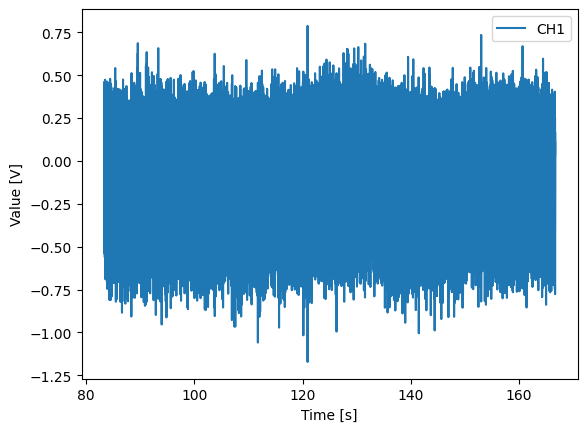

In [ ]:
def plot_data(column_name="CH5", start_index=None, end_index=None):
    # Default to using all data if start_index or end_index aren't specified
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data_frame)

    time_values = data_frame.iloc[start_index:end_index+1, 0]
    device_data = data_frame.loc[start_index:end_index, [column_name]]

    # Plot the column with time_values as the x-axis
    for column in device_data.columns:
        plt.plot(time_values, device_data[column], label=column)

    # Customize the plot
    plt.xlabel('Time [s]')
    plt.ylabel('Value [V]')
    plt.legend(device_data.columns, loc='best')

    # Show the plot
    plt.show()

# Call function with column name and start and end indices
plot_data("CH1", 1000000, 2000000)


In [ ]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["CH8"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((90, 91))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
#plt.title('D1 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()